In [ ]:
# run this only if you have not installed the requried packages
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install sklearn
!pip install rasterio
!pip install geopandas
!pip install fiona

# 1 - Feature Extraction

### Loading required libraries

In [1]:
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import classification_report, accuracy_score

### Providing the path to the data

In [2]:
# variables 
# Note: labels should be always last column with name "labels"
# Note: Make sure input labels shapefile and input raster have same CRS, otherwise code will not run

# input files
raster_loc = 'materials/rasters/s2image.tif'
points_loc = 'materials/shapefiles/samples.shp'
temp_point_loc = 'materials/temp/temp_y_points.shp'

# land cover names (for post visualization)
lulc_name = ['Water', 'Dense Veg', 'Veg', 'Impervious']

### Loading  data

### Visualizing the data

In [35]:
src = rio.open(raster_loc)

blue = src.read(1, masked=True)
green = src.read(2, masked=True)
red = src.read(3, masked=True)
nir = src.read(4, masked=True)

def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)
nirn = normalize(nir)

c:\Users\walee\miniconda3\envs\geo\Lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


### RGB Visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


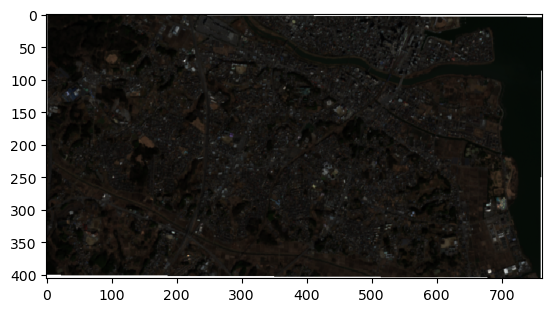

In [36]:
rgb = np.dstack((redn, greenn, bluen))

plt.imshow(rgb)

### False Color Composite Visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


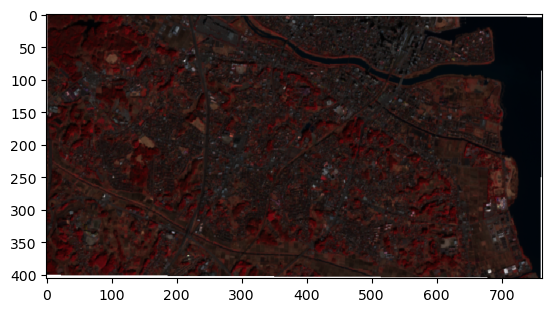

In [37]:
nrg = np.dstack((nirn, redn,greenn))

plt.imshow(nrg)

### Visualizing each bands

Text(0.5, 1.0, 'Blue')

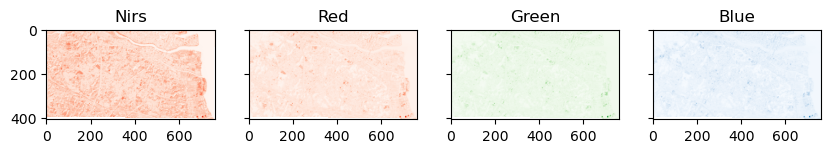

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

# Initialize subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(10, 4), sharey=True)

# Plot Red, Green and Blue (rgb)
ax1.imshow(nirn, cmap='Reds')
ax2.imshow(redn, cmap='Reds')
ax3.imshow(greenn, cmap='Greens')
ax4.imshow(bluen, cmap='Blues')

# Add titles
ax1.set_title("Nirs")
ax2.set_title("Red")
ax3.set_title("Green")
ax4.set_title("Blue")

In [4]:
#  reading bands from input
with rio.open(raster_loc) as img:
    bands = (img.read()).shape[0]
print('Bands of input image: ', bands)

# using ilteration to automatically create a bands list

features = []
for i in range(bands):
    features.append('band'+str(i+1))
print('Bands names: ', features)
f_len = len(features)

points = gpd.read_file(points_loc)
# adding a new column 'id' with range of points
points = points.assign(id=range(len(points)))
# saving nenw point file with 'id'
points.to_file(temp_point_loc) 
# converting gdf to pd df and removing geometry
points_df = pd.DataFrame(points.drop(columns='geometry'))

# ilterating over multiband raster
sampled = pd.Series()

#inputShape= temp_point_loc
# Read input shapefile with fiona and iterate over each feature
with fiona.open(temp_point_loc) as shp:
    for feature in shp:
        siteID = feature['properties']['id']
        coords = feature['geometry']['coordinates']
        # Read pixel value at the given coordinates using Rasterio
        # NB: `sample()` returns an iterable of ndarrays.
        with rio.open(raster_loc) as stack_src:
                  value = [v for v in stack_src.sample([coords])]
        # Update the pandas serie accordingly
        sampled.loc[siteID] = value

# reshaping sampled values
df1 = pd.DataFrame(sampled.values.tolist(), index=sampled.index)
df1['id'] = df1.index
df1 = pd.DataFrame(df1[0].values.tolist(), 
                   columns=features)
df1['id'] = df1.index

data = pd.merge(df1, points_df, on ='id')
print('Sampled Data: \n',data)

x = data.iloc[:,0:f_len]
X = x.values
y = data.iloc[:,-1]
Y = y.values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, stratify = Y)

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')


Bands of input image:  4
Bands names:  ['band1', 'band2', 'band3', 'band4']


<timed exec>:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Sampled Data: 
       band1   band2   band3   band4   id  labels
0    0.0268  0.0404  0.0228  0.0100    0     1.0
1    0.0284  0.0430  0.0248  0.0111    1     1.0
2    0.0272  0.0402  0.0234  0.0107    2     1.0
3    0.0258  0.0408  0.0231  0.0099    3     1.0
4    0.0248  0.0436  0.0228  0.0107    4     1.0
..      ...     ...     ...     ...  ...     ...
116  0.1066  0.1080  0.1208  0.1368  116     4.0
117  0.1022  0.1092  0.1192  0.1432  117     4.0
118  0.3632  0.3724  0.3644  0.3596  118     4.0
119  0.0849  0.0797  0.0773  0.0918  119     4.0
120  0.0818  0.0902  0.0934  0.1130  120     4.0

[121 rows x 6 columns]
X_train Shape: (84, 4)
X_test Shape: (37, 4)
y_train Shape: (84,)
y_test Shape:(37,)
CPU times: total: 1.3 s
Wall time: 1.77 s


# Support Vector Machine (SVM)

Accuracy SVM: 100.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         8
         2.0       1.00      1.00      1.00         8
         3.0       1.00      1.00      1.00         7
         4.0       1.00      1.00      1.00        14

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37

Confusion Matrix RF: 
 [[ 8  0  0  0]
 [ 0  8  0  0]
 [ 0  0  7  0]
 [ 0  0  0 14]]


Text(48.74999999999999, 0.5, 'Actual')

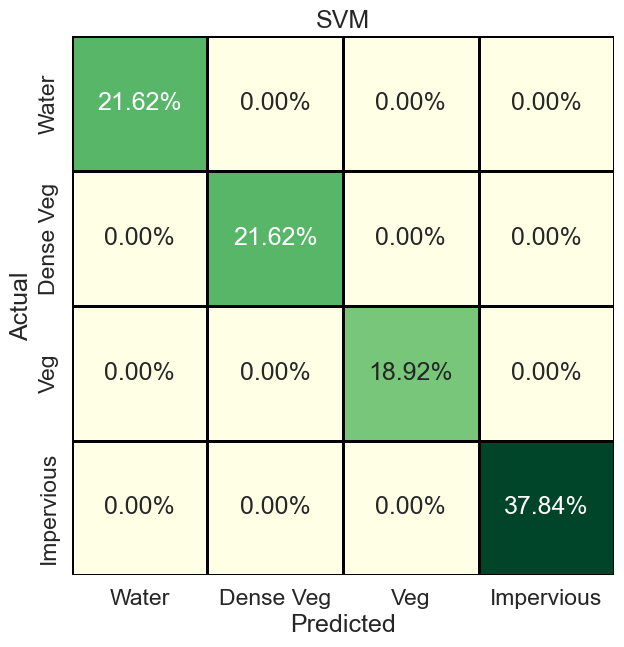

In [5]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
cName = 'SVM'
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

## full data reshaping, predicting, and saving output

In [6]:
%%time
cName = 'SVM'
exp_name = f'materials/results/lulc_{cName}.tif'


img = rio.open(raster_loc)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, f_len)
print('reshaped full data shape  for prediction: ',img_n.shape)
metadata = img.meta
height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')


pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')

img_reshape = pred_full.reshape(height, width)

out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

Height: 406
Width: 763
Bands: 4

reshaped full data shape  for prediction:  (309778, 4)
Prediction Done, now exporting raster 

Map saved SVM.................
CPU times: total: 875 ms
Wall time: 888 ms


## Random Forest

Accuracy RF: 94.5945945945946
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         8
         2.0       1.00      1.00      1.00         8
         3.0       1.00      0.71      0.83         7
         4.0       0.88      1.00      0.93        14

    accuracy                           0.95        37
   macro avg       0.97      0.93      0.94        37
weighted avg       0.95      0.95      0.94        37

Confusion Matrix RF: 
 [[ 8  0  0  0]
 [ 0  8  0  0]
 [ 0  0  5  2]
 [ 0  0  0 14]]
CPU times: total: 188 ms
Wall time: 519 ms


Text(48.74999999999999, 0.5, 'Actual')

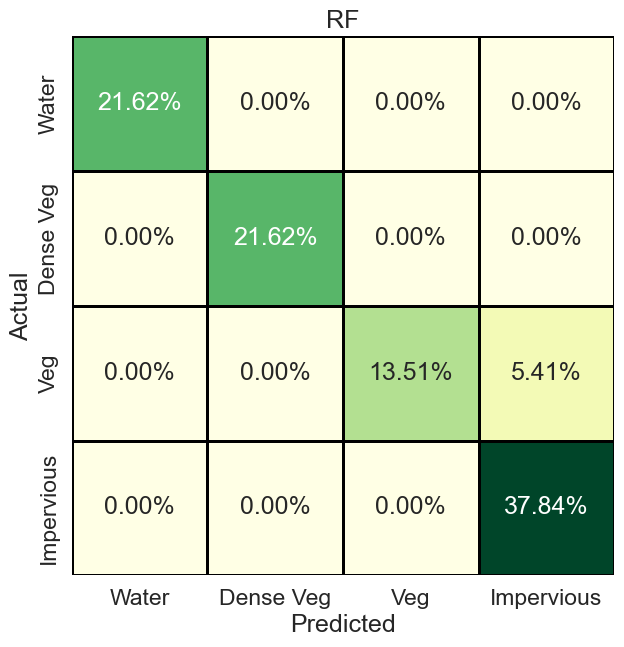

In [7]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

cName = 'RF'


clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

## full data reshaping, predicting, and saving output

In [9]:
%%time

cName = 'RF'
exp_name = f'materials/results/lulc_{cName}.tif'


img = rio.open(raster_loc)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, f_len)
print('reshaped full data shape  for prediction: ',img_n.shape)


pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')
# Predefining out raster meta using variable raster
tempfile_arr = img.read(1)
tempfile_arr = tempfile_arr.reshape(-1,1)
metadata = img.meta

height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

img_reshape = pred_full.reshape(height, width)

out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

Height: 406
Width: 763
Bands: 4

reshaped full data shape  for prediction:  (309778, 4)
Prediction Done, now exporting raster 

Map saved RF.................
CPU times: total: 1.44 s
Wall time: 1.48 s


## Decision Tree

Accuracy DT: 89.1891891891892
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         8
         2.0       1.00      1.00      1.00         8
         3.0       1.00      0.43      0.60         7
         4.0       0.78      1.00      0.88        14

    accuracy                           0.89        37
   macro avg       0.94      0.86      0.87        37
weighted avg       0.92      0.89      0.88        37

Confusion Matrix RF: 
 [[ 8  0  0  0]
 [ 0  8  0  0]
 [ 0  0  3  4]
 [ 0  0  0 14]]
CPU times: total: 31.2 ms
Wall time: 34.4 ms


Text(48.74999999999999, 0.5, 'Actual')

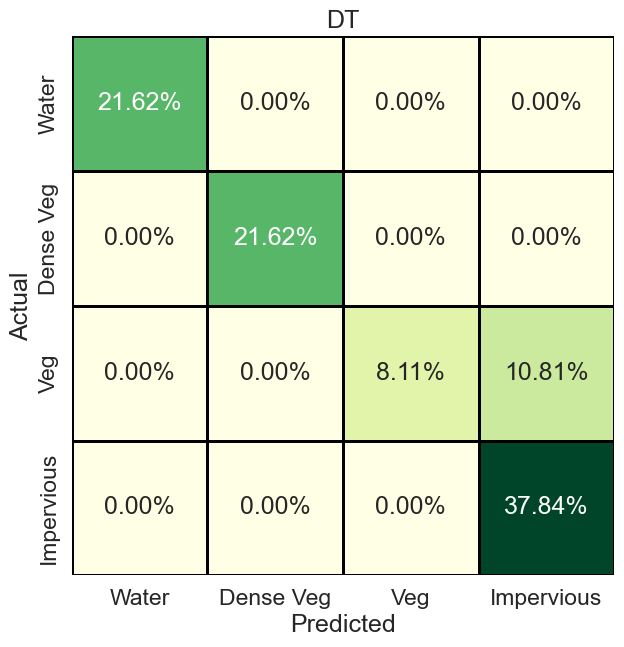

In [10]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

cName = 'DT'

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

In [11]:
%%time

cName = 'DT'
exp_name = f'materials/results/lulc_{cName}.tif'


img = rio.open(raster_loc)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, f_len)
print('reshaped full data shape  for prediction: ',img_n.shape)


pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')
# Predefining out raster meta using variable raster
tempfile_arr = img.read(1)
tempfile_arr = tempfile_arr.reshape(-1,1)
metadata = img.meta

height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

img_reshape = pred_full.reshape(height, width)

out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

Height: 406
Width: 763
Bands: 4

reshaped full data shape  for prediction:  (309778, 4)
Prediction Done, now exporting raster 

Map saved DT.................
CPU times: total: 46.9 ms
Wall time: 45.2 ms
